# Question A3

Find the optimal number of hidden neurons for first hidden layer of the 4-layer network (3 hidden layers, output layer) designed in Question 1 and 2

#### Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}. Continue using 5-fold cross validation on training dataset. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

This might take a while to run, approximately 20 - 30 min, so plan your time carefully.

1. Firstly, we import relevant libraries.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from common_utils import set_seed

# setting seed
set_seed()

2. To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [2]:
# YOUR CODE HERE
from common_utils import CustomDataset, MLP, intialise_loaders, loss_fn

from common_utils import split_dataset, preprocess_dataset

random_seed = 0

def preprocess(df):
    X_train, y_train, X_test, y_test = split_dataset(df, ['filename', 'label'], 0.3, random_seed)
    
    return X_train, y_train, X_test, y_test

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

print(df['label'].value_counts())

X_train, y_train, X_test, y_test = preprocess(df)

label
pos    6202
neg    5855
Name: count, dtype: int64


3. Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [5]:
def train(model, optimizer, loss_fn, n_epochs, X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size):
	train_data = CustomDataset(X_train_scaled, y_train2)
	val_data = CustomDataset(X_val_scaled, y_val2)

	train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
	val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    
	training_times_per_epoch = []
	training_accuracies_per_epoch = []
	training_losses_per_epoch = []

	test_accuracies_per_epoch = []
	test_losses_per_epoch = []

	for epoch in range(n_epochs):
		model.train()
		epoch_start_time = time.time()

		training_loss_per_batch = []
		training_accuracy_per_batch = []
		for X_batch, y_batch in train_loader:
			optimizer.zero_grad()
			y_pred = model(X_batch)

			loss = loss_fn(y_pred, y_batch)
			training_loss_per_batch.append(loss.detach().numpy())

			accuracy = (y_pred.round() == y_batch).float().mean()
			accuracy = float(accuracy)
			training_accuracy_per_batch.append(accuracy)

			loss.backward()
			optimizer.step()

		training_losses_per_epoch.append(sum(training_loss_per_batch) / len(training_loss_per_batch))
		training_accuracies_per_epoch.append(sum(training_accuracy_per_batch) / len(training_accuracy_per_batch))

		epoch_end_time = time.time()
		training_times_per_epoch.append(epoch_end_time - epoch_start_time)

		model.eval()
		test_accuracy_per_batch = []
		test_loss_per_batch = []
		for X_batch, y_batch in val_loader: # track accuracy
			y_pred = model(X_batch)

			loss = loss_fn(y_pred, y_batch)
			test_loss_per_batch.append(loss.detach().numpy())

			accuracy = (y_pred.round() == y_batch).float().mean()
			accuracy = float(accuracy)
			test_accuracy_per_batch.append(accuracy)

		test_accuracies_per_epoch.append(sum(test_accuracy_per_batch) / len(test_accuracy_per_batch))
		test_losses_per_epoch.append(sum(test_loss_per_batch) / len(test_loss_per_batch))

	return training_accuracies_per_epoch, training_losses_per_epoch, test_accuracies_per_epoch, test_losses_per_epoch, training_times_per_epoch

In [16]:
def find_optimal_hyperparameter(X, y, parameters, mode, batch_size):
	cross_validation_accuracies = {}
	epoch_training_times = {}
	training_accuracies = {}

	for neurons_in_first_hidden_layer in parameters:
		kf = KFold(n_splits = 5, shuffle=True, random_state=random_seed)
		for train_indices, val_indices in kf.split(X):
			X_train, X_val = X[train_indices], X[val_indices]
			y_train, y_val = y[train_indices], y[val_indices]

			scaler = preprocessing.StandardScaler()
			X_train_scaled = scaler.fit_transform(X_train)
			X_val_scaled = scaler.transform(X_val)

			model = MLP(77, [neurons_in_first_hidden_layer, 128, 128], 1)
			optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

			train_accuracies, train_losses, val_accuracies, val_losses, times = train(model, optimizer, loss_fn, 20, X_train_scaled, y_train, X_val_scaled, y_val, batch_size)
			cross_validation_accuracies[neurons_in_first_hidden_layer] = val_accuracies
			epoch_training_times[neurons_in_first_hidden_layer] = times[-1]
			training_accuracies[neurons_in_first_hidden_layer] = train_accuracies

	return cross_validation_accuracies, training_accuracies, epoch_training_times

'''
optimal_bs = 0. Fill your optimal batch size in the following code.
'''
# YOUR CODE HERE
num_neurons = [64, 128, 256]
optimal_bs = 256
cross_validation_accuracies, training_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train.to_numpy(), y_train, num_neurons, 'num_neurons', optimal_bs)

4. Plot the cross-validation accuracies against the number of epochs for different numbers of hidden-layer neurons. Limit the search space of the number of neurons to {64, 128, 256}.

Text(0, 0.5, 'Cross-validation accuracy')

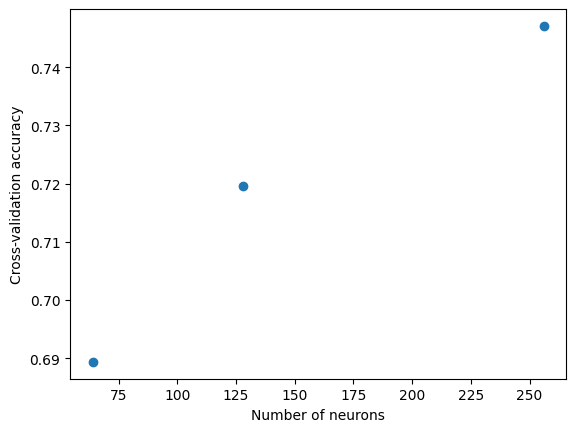

In [18]:
# YOUR CODE HERE
accuracies_to_plot = [cross_validation_accuracies[num_neuron][-1] for num_neuron in num_neurons]

plt.scatter(num_neurons, accuracies_to_plot)

plt.xlabel("Number of neurons")
plt.ylabel("Cross-validation accuracy")

5. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

In [14]:
optimal_neurons = 256
reason = "Highest cross-validation accuracy"
# YOUR CODE HERE

6. Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.

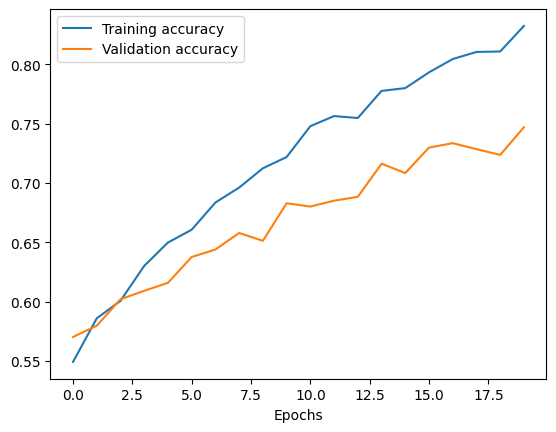

In [17]:
# YOUR CODE HERE
plt.plot(training_accuracies[256], label="Training accuracy")
plt.plot(cross_validation_accuracies[256], label="Validation accuracy")

plt.xlabel("Epochs")
plt.legend()